# Exercise 3

In [ ]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add("Plots")


## Stability of a Double Well 

Explore the stability of the system $$\frac{dx}{dt} = x - x^3.$$ What are the fixed points of the system and what's their stability? Which intervals of initial conditions lead to which of the stable fixed points?

#### Solution
The system has three fixed points an $x_{*1}=-1$, $x_{*2}=0$, $x_{*3}=1$. $x_{*1}$ and $x_{*3}$ are stable and $x_{*2}$ is unstable.

This ODE is also connected to a double well potential $V=-\frac{1}{2}x^2 + \frac{1}{4}x^4 +C$, and $\frac{dx}{dt} = f(x)= -\frac{dV}{dx}$. When we can write an ODE like this, we can also inspect this potential $V$. Trajectories / "Particles" always move towards minima of the potential. This also showcases very well that this is a bistable system. Initial conditions $x_0<0$ always move towards the minima at -1 wheareas initial conditions $x_0>0$ move towards the minima at +1. 

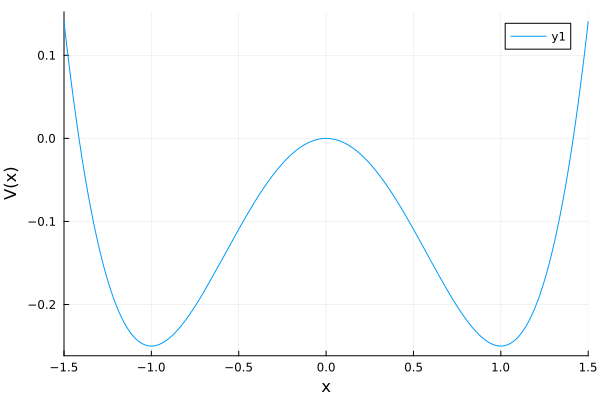

In [2]:
using Plots
plot(x->-0.5x^2 + 0.25x^4, xlims=[-1.5,1.5], ylabel="V(x)", xlabel="x")

## Phase Portraits and Lotka-Volterra

### Lotka-Volterra Model for Competition 

First, we do a slightly different Lotka-Volterra Model, its variation for competition. Imagine we have a population of rabbits and and one of sheeps. Both are competing for the same limited food supply (grass). Similar to the logistic growth model, each population will have its own carrying capacity. Both reproduce, but rabbits reproduce a bit faster than sheep. When a sheep and a rabbit compete for the same patch of grass, the sheep will more often "win" and chase the rabbit away than the other way around. These conflicts occur more often when the populations are larger, thus we assume they are directly proportional to their population. 

One of modelling this is done by the following equation: 

$\frac{dR}{dt} = R(3 - R - 2S)\\
\frac{dS}{dt} = S(2 - S - R)$

The first two terms correspond to the logistic growth of each seperate species, where rabbits reproduce a bit faster. The last term models the conflicts between two species. 

* Now, implement this model and plot a phase portrait similar to how it was done in the lecture. From the phase portrait deduct the stability of the system and what kind of behaviour occurs. 

#### Solution
- We will reimplement the code from the last exercise to make full use of Julia's parametric type system, as we saw in the lecture.
<br>

- Following the structure used in DifferentialEquations.jl, we will define new types for the ODE problem, the ODE solution, and ODE solvers. The `solve` method will then dispatch on the ODE solver type in order to apply the correct algorithm.
<br>

- We will use the type parameter `T` to denote a number type, e.g. `Float64`, throughout. Pay close attention to how we use this type parameter to ensure consistent number types throughout.

In [3]:
abstract type AbstractODEProblem{T} end

struct ODEProblem{
    T<:AbstractFloat,
    F<:Function,
    U<:AbstractVector{T},
    P<:Union{Nothing,AbstractVector{T}}  # This means the type of p can be other Nothing or a subtype of AbstractVector{T}
    } <: AbstractODEProblem{T}
    f::F
    u0::U  # Could also do u0::Vector{T}, but this way is slightly more flexible
    tspan::Tuple{T,T}
    p::P
end

In [4]:
abstract type AbstractODESolution{T} end

struct ODESolution{T<:AbstractFloat} <: AbstractODESolution{T}
    times::Vector{T}  # This is the other, less flexible way. How would you rewrite this to allow other types of Vector?
    u::Matrix{T}
end

In [5]:
abstract type AbstractODESolver{T} end

struct SimpleEulerSolver{T<:AbstractFloat} <: AbstractODESolver{T}
    Δt::T
end

function solve(prob::ODEProblem{T,F}, alg::SimpleEulerSolver{T}) where {T,F}  # We force prob and alg to use the same number format T
    (; f, u0, tspan, p) = prob  # "Unpack" the fields of prob into the local scope
    Δt = alg.Δt

    times = tspan[1]:Δt:tspan[2]

    u = zeros(T, length(u0), length(times))  # Pre-allocate the solution
    u[:,1] = u0
    
    for i = 2:length(times)
        t = times[i]
        uₙ = u[:,i-1]
        uₙ₊₁ = uₙ + Δt * f(uₙ, p, t)  # Simple Euler step
        u[:,i] = uₙ₊₁
    end

    return ODESolution{T}(times, u)
end

solve (generic function with 1 method)

In [6]:
struct ImprovedEulerSolver{T<:AbstractFloat} <: AbstractODESolver{T}
    Δt::T
end

function solve(prob::ODEProblem{T,F}, alg::ImprovedEulerSolver{T}) where {T,F}  # We force prob and alg to use the same number format T
    (; f, u0, tspan, p) = prob
    Δt = alg.Δt

    times = tspan[1]:Δt:tspan[2]

    u = zeros(T, length(u0), length(times))  # Pre-allocate the solution
    u[:,1] = u0

    for i = 2:length(times)
        t = times[i]
        uₙ = u[:,i-1]
        u_trial = uₙ + Δt * f(uₙ, p, t)                          # Trial step
        uₙ₊₁ = uₙ + 0.5 * Δt * (f(uₙ, p, t) + f(u_trial, p, t))  # Improved Euler step
        u[:,i] = uₙ₊₁
    end

    return ODESolution{T}(times, u)
end

solve (generic function with 2 methods)

In [7]:
# Add a method to the Plots.plot function that dispatches on our ODESolution type
using Plots

function Plots.plot(sol::ODESolution; xlabel = "", ylabel = "", label = "")
    (; times, u) = sol
    
    return plot(times, transpose(u); xlabel, ylabel, label)
end

Now we implement the update rule for the Lotka-Volterra model for competition and solve it.

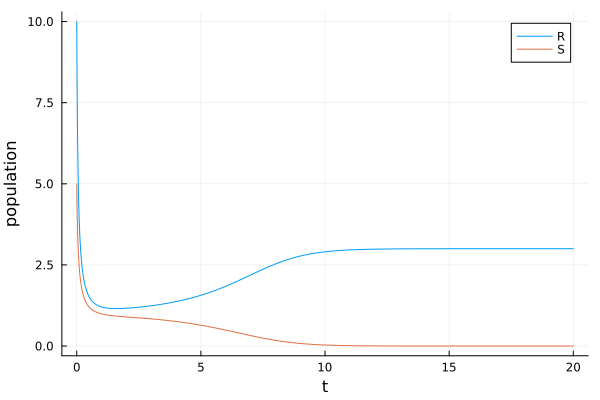

In [8]:
function competition(u, p, t)
    R, S = u
    return [R * (3 - R - 2S), S * (2 - S - R)]
end

p = nothing  # Remember from earlier that p can optionally have type Nothing

tspan = (0.0, 20.0)
Δt = 0.01

u0 = [10.0, 5.0]

prob = ODEProblem(competition, u0, tspan, p)
alg = ImprovedEulerSolver(Δt)
sol = solve(prob, alg)

plot(sol, xlabel = "t", ylabel = "population", label = ["R" "S"])

### Lotka-Volterra Model for Predetor-Prey Dynamics 

* Plot a phase portrait for the Lotka-Volterra model for predetor-prey dynamics as it given in the last exercises. What kind of dynamics can you see? 

#### Solution

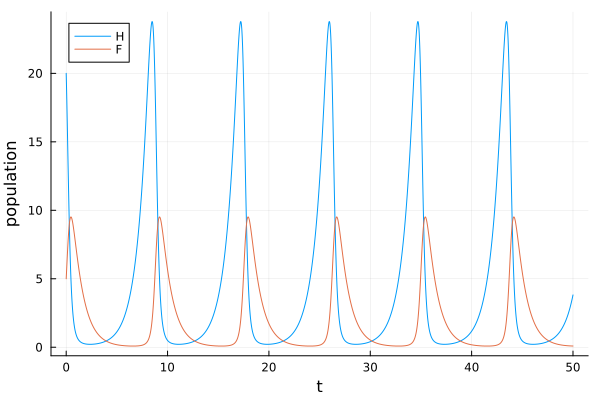

In [9]:
function predator_prey(u, p, t)
    H, F = u
    α, β, γ, δ = p
    return [α * H - β * H * F, δ * H * F - γ * F]
end

α = 1.0
β = 0.5
γ = 1.0
δ = 0.2
p = [α, β, γ, δ]

tspan = (0.0, 50.0)
Δt = 0.01

u0 = [20.0, 5.0]

prob = ODEProblem(predator_prey, u0, tspan, p)
alg = ImprovedEulerSolver(Δt)
sol = solve(prob, alg)

plot(sol, xlabel = "t", ylabel = "population", label = ["H" "F"])